In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Dataset path - update this to your actual path
DATASET_PATH = r'D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\CASIA-B_HRNet'

# Dataset parameters
NUM_KEYPOINTS = 17  # COCO format keypoints
KEYPOINT_DIMS = 3   # (x, y, confidence)
MAX_FRAMES = 67     # Maximum sequence length we observed
TARGET_FRAMES = 64  # Fixed sequence length for CNN (power of 2 is better)

print("Dataset path:", DATASET_PATH)
print("Expected keypoint format: (frames, keypoints, dims) =", f"({TARGET_FRAMES}, {NUM_KEYPOINTS}, {KEYPOINT_DIMS})")


Dataset path: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\CASIA-B_HRNet
Expected keypoint format: (frames, keypoints, dims) = (64, 17, 3)


In [4]:
def explore_dataset_structure(dataset_path):
    """Explore the structure of CASIA-B dataset"""
    subjects = []
    conditions = []
    views = []
    
    # Walk through dataset directory
    for subject in os.listdir(dataset_path):
        subject_path = os.path.join(dataset_path, subject)
        if not os.path.isdir(subject_path):
            continue
            
        subjects.append(subject)
        
        for condition in os.listdir(subject_path):
            condition_path = os.path.join(subject_path, condition)
            if not os.path.isdir(condition_path):
                continue
            
            if condition not in conditions:
                conditions.append(condition)
            
            for view in os.listdir(condition_path):
                view_path = os.path.join(condition_path, view)
                if not os.path.isdir(view_path):
                    continue
                
                if view not in views:
                    views.append(view)
    
    print(f"Number of subjects: {len(subjects)}")
    print(f"Subjects: {sorted(subjects)}")
    print(f"Conditions: {sorted(conditions)}")
    print(f"Views: {sorted(views)}")
    
    return sorted(subjects), sorted(conditions), sorted(views)

subjects, conditions, views = explore_dataset_structure(DATASET_PATH)


Number of subjects: 124
Subjects: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124']
Conditions: ['bg-01', 'bg-02', 'cl-01', 'cl-02', 'nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm

In [5]:
def load_sample_pkl(dataset_path, subject='001', condition='bg-01', view='000'):
    """Load a sample .pkl file to understand data format"""
    sample_path = os.path.join(dataset_path, subject, condition, view)
    
    if not os.path.exists(sample_path):
        print(f"Path does not exist: {sample_path}")
        return None
    
    pkl_files = [f for f in os.listdir(sample_path) if f.endswith('.pkl')]
    if not pkl_files:
        print(f"No .pkl files found in {sample_path}")
        return None
    
    pkl_file = pkl_files[0]  # Take first pkl file
    pkl_path = os.path.join(sample_path, pkl_file)
    
    print(f"Loading sample file: {pkl_path}")
    
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Data type: {type(data)}")
    print(f"Data shape: {data.shape}")
    print(f"Data dtype: {data.dtype}")    
    return data

# Load sample data
sample_data = load_sample_pkl(DATASET_PATH)


Loading sample file: D:\vit study\Machine Learning\Gait\CASIA - B\CASIA - B\CASIA-B_HRNet\001\bg-01\000\000.pkl
Data type: <class 'numpy.ndarray'>
Data shape: (98, 17, 3)
Data dtype: float32


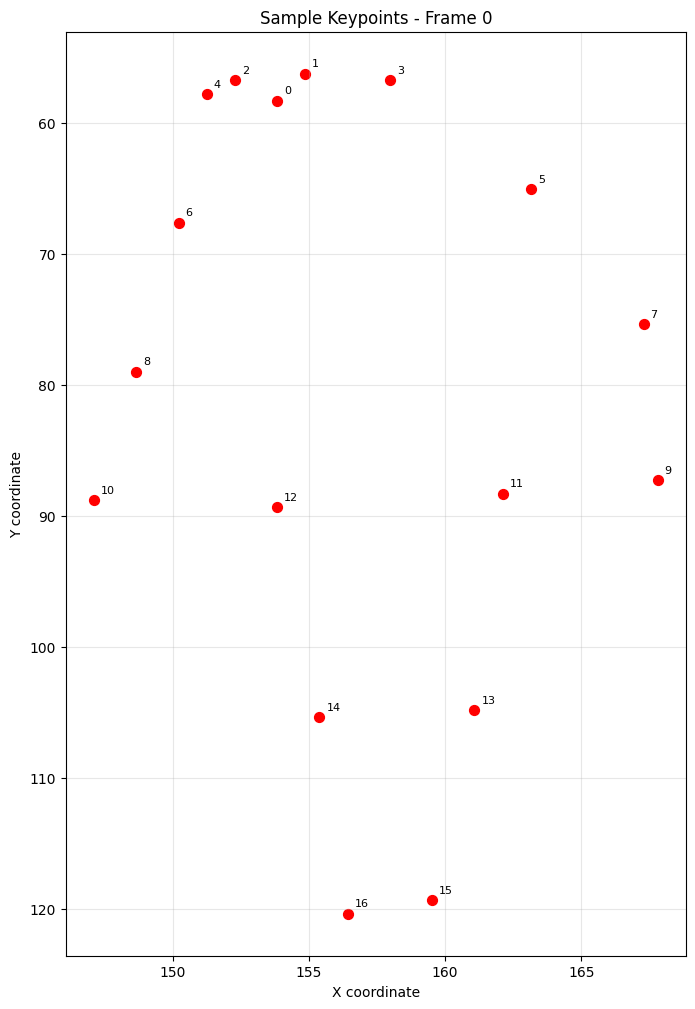

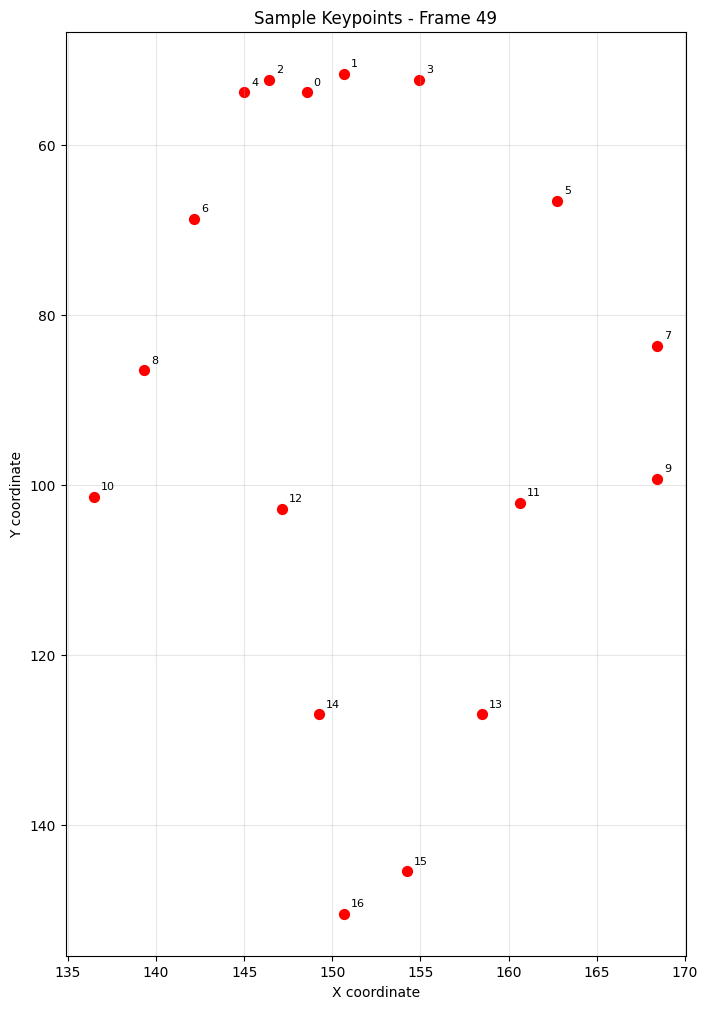

In [13]:
def plot_keypoints(keypoint_data, frame_idx=0, title="Sample Keypoints"):
    """Plot keypoints for a specific frame"""
    if keypoint_data is None:
        return
    
    frame_keypoints = keypoint_data[frame_idx]  # Shape: (17, 3)
    
    # Extract x, y coordinates (ignore confidence for visualization)
    x = frame_keypoints[:, 0]
    y = frame_keypoints[:, 1]
    
    plt.figure(figsize=(8, 12))
    plt.scatter(x, y, c='red', s=50)
    
    # Add keypoint labels (COCO format)
    """keypoint_names = [
        'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
        'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
        'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
    ]"""
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(f'{i}', (xi, yi), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.gca().invert_yaxis()  # Invert y-axis for correct visualization
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title(f'{title} - Frame {frame_idx}')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot sample keypoints
if sample_data is not None:
    plot_keypoints(sample_data, frame_idx=0)
    plot_keypoints(sample_data, frame_idx=sample_data.shape[0]//2)  # Middle frame


In [7]:
def collect_all_data_paths(dataset_path, subjects=None, conditions=None, views=None):
    """Collect all data paths with labels"""
    data_paths = []
    
    if subjects is None:
        subjects = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    
    for subject in subjects:
        subject_path = os.path.join(dataset_path, subject)
        if not os.path.exists(subject_path):
            continue
            
        for condition in os.listdir(subject_path):
            condition_path = os.path.join(subject_path, condition)
            if not os.path.isdir(condition_path):
                continue
            
            if conditions and condition not in conditions:
                continue
                
            for view in os.listdir(condition_path):
                view_path = os.path.join(condition_path, view)
                if not os.path.isdir(view_path):
                    continue
                
                if views and view not in views:
                    continue
                
                # Find pkl files in this view directory
                pkl_files = [f for f in os.listdir(view_path) if f.endswith('.pkl')]
                
                for pkl_file in pkl_files:
                    pkl_path = os.path.join(view_path, pkl_file)
                    data_paths.append({
                        'path': pkl_path,
                        'subject': subject,
                        'condition': condition,
                        'view': view,
                        'filename': pkl_file
                    })
    
    return data_paths

# Collect all data paths
all_data_paths = collect_all_data_paths(DATASET_PATH)
print(f"Total number of sequences found: {len(all_data_paths)}")

# Show distribution by subject
df_paths = pd.DataFrame(all_data_paths)
print("\nSequences per subject:")
print(df_paths['subject'].value_counts().head(10))
print("\nSequences per condition:")
print(df_paths['condition'].value_counts())
print("\nSequences per view:")
print(df_paths['view'].value_counts())


Total number of sequences found: 13637

Sequences per subject:
subject
001    110
002    110
003    110
004    110
005    110
006    110
007    110
008    110
009    110
010    110
Name: count, dtype: int64

Sequences per condition:
condition
bg-01    1364
bg-02    1364
cl-01    1364
cl-02    1364
nm-02    1364
nm-04    1364
nm-06    1364
nm-05    1364
nm-03    1363
nm-01    1362
Name: count, dtype: int64

Sequences per view:
view
018    1240
036    1240
054    1240
126    1240
072    1240
090    1240
108    1240
180    1240
162    1240
144    1239
000    1238
Name: count, dtype: int64


In [8]:
def preprocess_keypoints(keypoint_data, target_frames=TARGET_FRAMES, normalize=True):
    """
    Preprocess keypoint sequences:
    - Pad or truncate to target_frames
    - Normalize coordinates
    - Handle missing keypoints
    """
    original_frames = keypoint_data.shape[0]
    
    # Pad or truncate sequence to target_frames
    if original_frames < target_frames:
        # Pad by repeating last frame
        padding_needed = target_frames - original_frames
        last_frame = keypoint_data[-1:].repeat(padding_needed, axis=0)
        keypoint_data = np.concatenate([keypoint_data, last_frame], axis=0)
    elif original_frames > target_frames:
        # Truncate to target_frames
        keypoint_data = keypoint_data[:target_frames]
    
    if normalize:
        # Normalize x, y coordinates to [0, 1] range
        # Find min/max across all frames for this sequence
        x_coords = keypoint_data[:, :, 0]  # All x coordinates
        y_coords = keypoint_data[:, :, 1]  # All y coordinates
        
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        
        # Avoid division by zero
        if x_max - x_min > 0:
            keypoint_data[:, :, 0] = (x_coords - x_min) / (x_max - x_min)
        if y_max - y_min > 0:
            keypoint_data[:, :, 1] = (y_coords - y_min) / (y_max - y_min)
        
        # Keep confidence scores as they are (already in reasonable range)
    
    return keypoint_data

def load_and_preprocess_sequence(file_path):
    """Load and preprocess a single sequence"""
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Preprocess the keypoints
        processed_data = preprocess_keypoints(data)
        return processed_data
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Test preprocessing on sample data
if sample_data is not None:
    processed_sample = preprocess_keypoints(sample_data.copy())
    print(f"Original shape: {sample_data.shape}")
    print(f"Processed shape: {processed_sample.shape}")
    print(f"Original data range: [{sample_data.min():.3f}, {sample_data.max():.3f}]")
    print(f"Processed data range: [{processed_sample.min():.3f}, {processed_sample.max():.3f}]")


Original shape: (98, 17, 3)
Processed shape: (64, 17, 3)
Original data range: [0.745, 237.254]
Processed data range: [0.000, 1.000]


In [9]:
def build_dataset(data_paths, max_samples=None, test_size=0.2):
    """Build dataset from data paths"""
    if max_samples:
        data_paths = data_paths[:max_samples]
    
    X = []
    y_subject = []
    y_condition = []
    y_view = []
    
    print(f"Loading {len(data_paths)} sequences...")
    
    for i, data_info in enumerate(data_paths):
        if i % 100 == 0:
            print(f"Loading sequence {i+1}/{len(data_paths)}")
        
        # Load and preprocess sequence
        sequence = load_and_preprocess_sequence(data_info['path'])
        
        if sequence is not None:
            X.append(sequence)
            y_subject.append(data_info['subject'])
            y_condition.append(data_info['condition'])
            y_view.append(data_info['view'])
    
    print(f"Successfully loaded {len(X)} sequences")
    
    # Convert to numpy arrays
    X = np.array(X)  # Shape: (n_samples, target_frames, 17, 3)
    
    # Encode labels
    subject_encoder = LabelEncoder()
    condition_encoder = LabelEncoder()
    view_encoder = LabelEncoder()
    
    y_subject_encoded = subject_encoder.fit_transform(y_subject)
    y_condition_encoded = condition_encoder.fit_transform(y_condition)
    y_view_encoded = view_encoder.fit_transform(y_view)
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of subjects: {len(subject_encoder.classes_)}")
    print(f"Number of conditions: {len(condition_encoder.classes_)}")
    print(f"Number of views: {len(view_encoder.classes_)}")
    
    return X, y_subject_encoded, y_condition_encoded, y_view_encoded, subject_encoder, condition_encoder, view_encoder

# Build dataset (start with smaller sample for testing)
print("Building dataset...")
X, y_subjects, y_conditions, y_views, subject_encoder, condition_encoder, view_encoder = build_dataset(
    all_data_paths  # Start with 1000 samples for testing
)


Building dataset...
Loading 13637 sequences...
Loading sequence 1/13637
Loading sequence 101/13637
Loading sequence 201/13637
Loading sequence 301/13637
Loading sequence 401/13637
Loading sequence 501/13637
Loading sequence 601/13637
Loading sequence 701/13637
Loading sequence 801/13637
Loading sequence 901/13637
Loading sequence 1001/13637
Loading sequence 1101/13637
Loading sequence 1201/13637
Loading sequence 1301/13637
Loading sequence 1401/13637
Loading sequence 1501/13637
Loading sequence 1601/13637
Loading sequence 1701/13637
Loading sequence 1801/13637
Loading sequence 1901/13637
Loading sequence 2001/13637
Loading sequence 2101/13637
Loading sequence 2201/13637
Loading sequence 2301/13637
Loading sequence 2401/13637
Loading sequence 2501/13637
Loading sequence 2601/13637
Loading sequence 2701/13637
Loading sequence 2801/13637
Loading sequence 2901/13637
Loading sequence 3001/13637
Loading sequence 3101/13637
Loading sequence 3201/13637
Loading sequence 3301/13637
Loading seque

In [10]:
# Use subject recognition as main task
y_main = y_subjects
n_classes = len(subject_encoder.classes_)

print(f"Main task: Subject recognition with {n_classes} classes")
print(f"Dataset shape: {X.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_main, test_size=0.3, random_state=42, stratify=y_main
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print(f"Training labels shape: {y_train_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")


Main task: Subject recognition with 124 classes
Dataset shape: (13637, 64, 17, 3)
Training set: (9545, 64, 17, 3), (9545,)
Test set: (4092, 64, 17, 3), (4092,)
Training labels shape: (9545, 124)
Test labels shape: (4092, 124)


In [11]:
def create_1d_cnn_model(input_shape, num_classes):
    """
    Alternative: 1D CNN that treats sequences as time series
    Input shape: (frames, keypoints, coordinates) = (64, 17, 3)
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Flatten keypoints and coordinates for each frame
        layers.Reshape((input_shape[0], input_shape[1] * input_shape[2])),  # (64, 51)
        
        # 1D Convolutional layers - temporal patterns
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Dropout(0.25),
        
        # Global pooling
        layers.GlobalAveragePooling1D(),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create alternative 1D CNN model
model= create_1d_cnn_model(input_shape, n_classes)

"""# Compile the model
model_1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)"""
from tensorflow.keras.optimizers.schedules import CosineDecay
import tensorflow as tf

lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    alpha=1e-4
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print("1D CNN Model Summary:")
model.summary()


NameError: name 'input_shape' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Training parameters
BATCH_SIZE = 64
EPOCHS = 50

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]


print("Training setup complete!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {n_classes}")


Training setup complete!
Batch size: 64
Max epochs: 50
Input shape: (64, 17, 3)
Number of classes: 124


In [ ]:


print(f"Training model with input shape: {X_train.shape}")
print(f"Training labels shape: {y_train_cat.shape}")

# Train the model
"""history = chosen_model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=1
)"""
import tensorflow as tf

def augment(x, y):
    noise = tf.random.normal(shape=tf.shape(x[:, :, :2]), mean=0.0, stddev=0.01)
    x_xy = x[:, :, :2] + noise
    x = tf.concat([x_xy, x[:, :, 2:]], axis=-1)
    return x, y

def make_tf_dataset(X, y, batch_size=64, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=2000)
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = make_tf_dataset(X_train, y_train_cat, batch_size=64, training=True)
test_dataset  = make_tf_dataset(X_test,  y_test_cat,  batch_size=64, training=False)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Training model with input shape: (9545, 64, 17, 3)
Training labels shape: (9545, 124)
Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0079 - loss: 4.8976
Epoch 1: val_accuracy improved from None to 0.00733, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.0084 - loss: 4.8619 - val_accuracy: 0.0073 - val_loss: 4.8214
Epoch 2/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0083 - loss: 4.8313
Epoch 2: val_accuracy improved from 0.00733 to 0.00806, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0092 - loss: 4.8279 - val_accuracy: 0.0081 - val_loss: 4.8241
Epoch 3/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0120 - loss: 4.7913
Epoch 3: val_accuracy improved from 0.00806 to 0.00880, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0142 - loss: 4.7585 - val_accuracy: 0.0088 - val_loss: 5.0219
Epoch 4/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0167 - loss: 4.6330
Epoch 4: val_accuracy improved from 0.00880 to 0.01784, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0181 - loss: 4.5845 - val_accuracy: 0.0178 - val_loss: 4.8354
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0315 - loss: 4.4134
Epoch 5: val_accuracy did not improve from 0.01784
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0338 - loss: 4.3513 - val_accuracy: 0.0081 - val_loss: 12.5986
Epoch 6/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0368 - loss: 4.2096
Epoch 6: val_accuracy did not improve from 0.01784
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0381 - loss: 4.1706 - val_accuracy: 0.0088 - val_loss: 8.1485
Epoch 7/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0509 - loss: 4.0725
Epoch 7: val_accuracy did not improve from 0.01784
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0535 - loss: 4.0395 - val_accuracy: 0.0086 - val_loss: 15.7967
Epoch 8/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0550 - loss: 3.9656
Epoch 8: val_accuracy

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0650 - loss: 3.8212 - val_accuracy: 0.0320 - val_loss: 4.8002
Epoch 10/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0694 - loss: 3.7749
Epoch 10: val_accuracy did not improve from 0.03201
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.0741 - loss: 3.7555 - val_accuracy: 0.0298 - val_loss: 7.8805
Epoch 11/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0792 - loss: 3.6605
Epoch 11: val_accuracy did not improve from 0.03201
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0805 - loss: 3.6664 - val_accuracy: 0.0095 - val_loss: 14.5090
Epoch 12/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0890 - loss: 3.6267
Epoch 12: val_accuracy did not improve from 0.03201
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.0929 - loss: 3.6137 - val_accuracy: 0.0261 - val_loss: 6.1755
Epoch 13/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0925 - loss: 3.6047
Epoch 13: val_a

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0985 - loss: 3.5583 - val_accuracy: 0.0401 - val_loss: 5.5880
Epoch 14/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1068 - loss: 3.4807
Epoch 14: val_accuracy improved from 0.04008 to 0.10435, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.1085 - loss: 3.4749 - val_accuracy: 0.1043 - val_loss: 3.6084
Epoch 15/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1170 - loss: 3.4358
Epoch 15: val_accuracy did not improve from 0.10435
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1158 - loss: 3.4272 - val_accuracy: 0.0445 - val_loss: 5.9396
Epoch 16/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1308 - loss: 3.3536
Epoch 16: val_accuracy did not improve from 0.10435
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1321 - loss: 3.3321 - val_accuracy: 0.0403 - val_loss: 6.0043
Epoch 17/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1296 - loss: 3.3231
Epoch 17: val_accuracy did not improve from 0.10435
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.1371 - loss: 3.3102 - val_accuracy: 0.0628 - val_loss: 4.5342
Epoch 18/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1456 - loss: 3.2617
Epoch 18: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2038 - loss: 2.9520 - val_accuracy: 0.1696 - val_loss: 3.4094
Epoch 23/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2185 - loss: 2.8840
Epoch 23: val_accuracy did not improve from 0.16960
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2233 - loss: 2.8751 - val_accuracy: 0.0296 - val_loss: 12.0571
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2247 - loss: 2.8510
Epoch 24: val_accuracy improved from 0.16960 to 0.18915, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.2330 - loss: 2.8270 - val_accuracy: 0.1891 - val_loss: 3.0231
Epoch 25/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2473 - loss: 2.7624
Epoch 25: val_accuracy did not improve from 0.18915
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.2477 - loss: 2.7439 - val_accuracy: 0.1672 - val_loss: 3.3173
Epoch 26/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2659 - loss: 2.7002
Epoch 26: val_accuracy improved from 0.18915 to 0.24316, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2677 - loss: 2.6751 - val_accuracy: 0.2432 - val_loss: 2.9947
Epoch 27/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2745 - loss: 2.6409
Epoch 27: val_accuracy did not improve from 0.24316
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.2817 - loss: 2.6141 - val_accuracy: 0.1738 - val_loss: 3.4370
Epoch 28/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2737 - loss: 2.5662
Epoch 28: val_accuracy did not improve from 0.24316
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2848 - loss: 2.5385 - val_accuracy: 0.1161 - val_loss: 4.7798
Epoch 29/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3062 - loss: 2.4491
Epoch 29: val_accuracy did not improve from 0.24316
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3042 - loss: 2.4668 - val_accuracy: 0.1579 - val_loss: 3.6600
Epoch 30/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3273 - loss: 2.3867
Epoch 30: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3486 - loss: 2.3223 - val_accuracy: 0.3214 - val_loss: 2.4243
Epoch 32/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3411 - loss: 2.3041
Epoch 32: val_accuracy improved from 0.32136 to 0.32576, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.3531 - loss: 2.2661 - val_accuracy: 0.3258 - val_loss: 2.4526
Epoch 33/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3641 - loss: 2.2441
Epoch 33: val_accuracy did not improve from 0.32576
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.3640 - loss: 2.2478 - val_accuracy: 0.1948 - val_loss: 3.6849
Epoch 34/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3842 - loss: 2.1916
Epoch 34: val_accuracy improved from 0.32576 to 0.38172, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3809 - loss: 2.1828 - val_accuracy: 0.3817 - val_loss: 2.1524
Epoch 35/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3921 - loss: 2.1381
Epoch 35: val_accuracy did not improve from 0.38172
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.3841 - loss: 2.1409 - val_accuracy: 0.3592 - val_loss: 2.2888
Epoch 36/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3962 - loss: 2.0764
Epoch 36: val_accuracy did not improve from 0.38172
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.3988 - loss: 2.0803 - val_accuracy: 0.3448 - val_loss: 2.3403
Epoch 37/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3966 - loss: 2.0583
Epoch 37: val_accuracy did not improve from 0.38172
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4040 - loss: 2.0462 - val_accuracy: 0.3781 - val_loss: 2.2327
Epoch 38/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4235 - loss: 1.9767
Epoch 38: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4199 - loss: 1.9935 - val_accuracy: 0.3861 - val_loss: 2.1276
Epoch 39/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4232 - loss: 1.9513
Epoch 39: val_accuracy did not improve from 0.38612
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4217 - loss: 1.9671 - val_accuracy: 0.3543 - val_loss: 2.2941
Epoch 40/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4433 - loss: 1.9464
Epoch 40: val_accuracy did not improve from 0.38612
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4304 - loss: 1.9505 - val_accuracy: 0.2258 - val_loss: 3.2901
Epoch 41/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4472 - loss: 1.8870
Epoch 41: val_accuracy did not improve from 0.38612
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4482 - loss: 1.8913 - val_accuracy: 0.3717 - val_loss: 2.2814
Epoch 42/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4590 - loss: 1.8368
Epoch 42: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4577 - loss: 1.8278 - val_accuracy: 0.4374 - val_loss: 1.9455
Epoch 44/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4685 - loss: 1.8268
Epoch 44: val_accuracy improved from 0.43744 to 0.55596, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4617 - loss: 1.8357 - val_accuracy: 0.5560 - val_loss: 1.5409
Epoch 45/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4742 - loss: 1.7880
Epoch 45: val_accuracy did not improve from 0.55596
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4746 - loss: 1.7776 - val_accuracy: 0.3468 - val_loss: 2.3911
Epoch 46/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4772 - loss: 1.7741
Epoch 46: val_accuracy did not improve from 0.55596
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4808 - loss: 1.7590 - val_accuracy: 0.5259 - val_loss: 1.6290
Epoch 47/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4839 - loss: 1.7416
Epoch 47: val_accuracy did not improve from 0.55596
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4840 - loss: 1.7505 - val_accuracy: 0.4770 - val_loss: 1.7924
Epoch 48/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4869 - loss: 1.7179
Epoch 48: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5048 - loss: 1.6568 - val_accuracy: 0.5926 - val_loss: 1.4395
Epoch 51/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5012 - loss: 1.6449
Epoch 51: val_accuracy did not improve from 0.59262
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4994 - loss: 1.6493 - val_accuracy: 0.5853 - val_loss: 1.4598
Epoch 52/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5090 - loss: 1.6294
Epoch 52: val_accuracy did not improve from 0.59262
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5125 - loss: 1.6284 - val_accuracy: 0.5122 - val_loss: 1.6437
Epoch 53/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5063 - loss: 1.6085
Epoch 53: val_accuracy did not improve from 0.59262
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5078 - loss: 1.6167 - val_accuracy: 0.5330 - val_loss: 1.6016
Epoch 54/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5171 - loss: 1.5952
Epoch 54: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5175 - loss: 1.6030 - val_accuracy: 0.6119 - val_loss: 1.3578
Epoch 55/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5267 - loss: 1.5903
Epoch 55: val_accuracy did not improve from 0.61193
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5210 - loss: 1.5918 - val_accuracy: 0.6017 - val_loss: 1.3557
Epoch 56/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5258 - loss: 1.5777
Epoch 56: val_accuracy improved from 0.61193 to 0.62195, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5239 - loss: 1.5990 - val_accuracy: 0.6219 - val_loss: 1.3242
Epoch 57/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5383 - loss: 1.5201
Epoch 57: val_accuracy did not improve from 0.62195
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5285 - loss: 1.5564 - val_accuracy: 0.6146 - val_loss: 1.3213
Epoch 58/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5182 - loss: 1.5910
Epoch 58: val_accuracy did not improve from 0.62195
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5190 - loss: 1.5907 - val_accuracy: 0.6175 - val_loss: 1.3203
Epoch 59/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5247 - loss: 1.5675
Epoch 59: val_accuracy did not improve from 0.62195
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5278 - loss: 1.5616 - val_accuracy: 0.6068 - val_loss: 1.3382
Epoch 60/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5211 - loss: 1.5674
Epoch 60: val_ac

150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5292 - loss: 1.5401 - val_accuracy: 0.6317 - val_loss: 1.2685
Epoch 61/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5416 - loss: 1.5361
Epoch 61: val_accuracy did not improve from 0.63172
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5408 - loss: 1.5469 - val_accuracy: 0.6266 - val_loss: 1.2819
Epoch 62/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5361 - loss: 1.5405
Epoch 62: val_accuracy improved from 0.63172 to 0.63587, saving model to best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5333 - loss: 1.5491 - val_accuracy: 0.6359 - val_loss: 1.2505
Epoch 63/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5272 - loss: 1.5303
Epoch 63: val_accuracy did not improve from 0.63587
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5346 - loss: 1.5377 - val_accuracy: 0.6354 - val_loss: 1.2544
Epoch 64/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5416 - loss: 1.5309
Epoch 64: val_accuracy did not improve from 0.63587
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5383 - loss: 1.5317 - val_accuracy: 0.6317 - val_loss: 1.2550
Epoch 65/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5355 - loss: 1.5283
Epoch 65: val_accuracy did not improve from 0.63587
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5357 - loss: 1.5355 - val_accuracy: 0.6303 - val_loss: 1.2509
Epoch 66/100
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5406 - loss: 1.5148
Epoch 66: val_ac

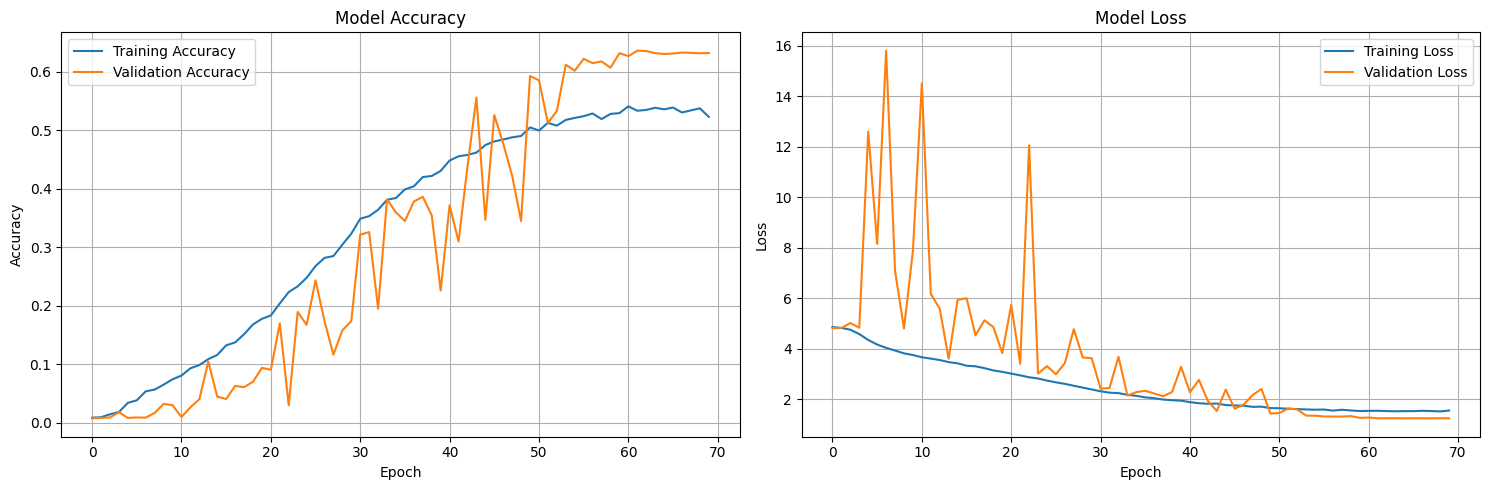

In [ ]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results after training
plot_training_history(history)
